In [190]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import math
import gzip
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from utils_atac import BuildMatrix, printMatrix, binarize, get_matrix, get_nodeDegree_ForEachNode, get_NodeDegree, get_confidentLinks
from bed_manipulate import bed_intersection, bed_w_NoIntersection, bed_closest

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
DATADIR='/users/mtaranov/3D_fromATAC/data/'
PromoterCaptureFile=DATADIR+'PromoterCapture_Digest_Human_HindIII_baits_ID.bed'
ATACPeakFile=DATADIR+'SORTED_primary_keratinocyte-d00.GGR.Stanford_Greenleaf.ATAC-seq.b1.trim.PE2SE.nodup.tn5_pooled.pf.pval0.1.500000.naive_overlap.narrowPeak.gz'
ATACPeakIDRFile=DATADIR+'primary_keratinocyte-d00.GGR.Stanford_Greenleaf.ATAC-seq_rep1-rep2.IDR0.1.filt.narrowPeak.gz'
OutputFile=DATADIR+'out.bed'
#InteractionsFileCaptureC='/mnt/lab_data/kundaje/mtaranov/ChicagoCalls/D0_D2D8_merge_BaitToBait_intra_score_gt_0.bed.gz'
InteractionsFileCaptureC_all='/mnt/lab_data/kundaje/mtaranov/ChicagoCalls/D0_D2D8_merge_BaitToBait_intra.bed.gz'

In [192]:
def get_links_vs_dist(InteractionsFileCaptureC, thres_min, thres_max):
    dist=[]
    scores=[]
    for line in gzip.open(InteractionsFileCaptureC,'r'):
        words=line.rstrip().split()
        chr1=words[0]
        start1=float(words[1])
        end1=float(words[2])
        chr2=words[3]
        start2=float(words[4])
        end2=float(words[5])
        score=float(words[6])
        d=abs((end2+start2)/2-(end1+start1)/2)
        if thres_min < d <= thres_max:
            dist.append(d/1000000)
            scores.append(score)
    return scores, dist

In [193]:
def plot_links_vs_dist(scores, dist):
    plt.scatter(dist, scores, c=scores)
    plt.xlabel('Distance btw interacting pair of nodes - HindIII sites, Mb')
    plt.ylabel('Score')
    plt.show()
    return 

In [228]:
def get_pos_neg_at_dist(InteractionsFileCaptureC, thres_min, thres_max, bin_size, score_thres):
    bins = [i/bin_size for i in range(thres_min, thres_max, bin_size)]
    pos={}
    neg={}
    for bin in bins:
        pos.update({int(bin):[]})
        neg.update({int(bin):[]})
    for line in gzip.open(InteractionsFileCaptureC,'r'):
        words=line.rstrip().split()
        chr1=words[0]
        start1=float(words[1])
        end1=float(words[2])
        chr2=words[3]
        start2=float(words[4])
        end2=float(words[5])
        score=float(words[6])
        d=abs((end2+start2)/2-(end1+start1)/2)
        if thres_min < d <= thres_max:
            bin = int(math.floor(d/bin_size))
            if score == 0:
                neg[bin].append(score)
            else:
                if score >= score_thres:
                    pos[bin].append(score)
    return pos, neg

In [245]:
scores_5kb_2Mb, dist_5kb_2Mb=get_links_vs_dist(InteractionsFileCaptureC_all, 10000, 2000000)

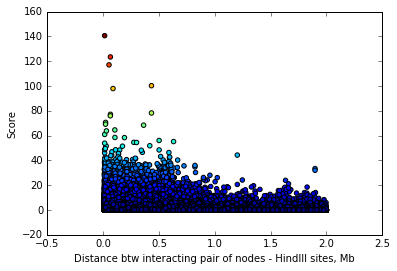

In [246]:
plot_links_vs_dist(scores_5kb_2Mb, dist_5kb_2Mb)

In [247]:
pos, neg = get_pos_neg_at_dist(InteractionsFileCaptureC_all, 0, 2000000, 10000, 0)

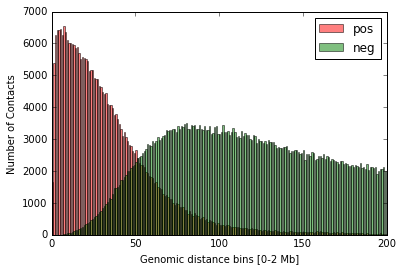

In [239]:
import matplotlib.ticker as ticker
plt.bar(pos.keys(), [len(i) for i in pos.values()], alpha=0.5, color='r',  label='pos')
plt.bar(pos.keys(), [len(i) for i in neg.values()], alpha=0.5, color='g',  label='neg')
plt.xlabel('Genomic distance bins [0-2 Mb]')
plt.ylabel('Number of Contacts')
plt.legend(loc='upper right')
#tick_locs = [0, 15, 100, 250, 200]
#tick_lbls = [i*10 for i in tick_locs]
#plt.xticks(tick_locs, tick_lbls)
plt.show()

In [249]:
print "pos = ", sum([len(i) for i in pos.values()]), " neg = ", sum([len(i) for i in neg.values()])

pos =  304556  neg =  455320


In [250]:
pos, neg = get_pos_neg_at_dist(InteractionsFileCaptureC_all, 0, 2000000, 10000, 5)

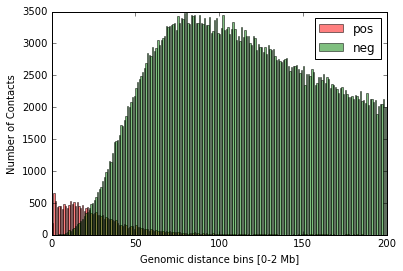

In [251]:
import matplotlib.ticker as ticker
plt.bar(pos.keys(), [len(i) for i in pos.values()], alpha=0.5, color='r',  label='pos')
plt.bar(pos.keys(), [len(i) for i in neg.values()], alpha=0.5, color='g',  label='neg')
plt.xlabel('Genomic distance bins [0-2 Mb]')
plt.ylabel('Number of Contacts')
plt.legend(loc='upper right')
#tick_locs = [0, 15, 100, 250, 200]
#tick_lbls = [i*10 for i in tick_locs]
#plt.xticks(tick_locs, tick_lbls)
plt.show()

In [252]:
print "pos = ", sum([len(i) for i in pos.values()]), " neg = ", sum([len(i) for i in neg.values()])

pos =  19543  neg =  455320


Some tests on adjacency matrix:
Adjacency matrix is symmetric
Average q-value with zeros:  0.0140628094225
Average q-value w/o zeros:  1.63488124936


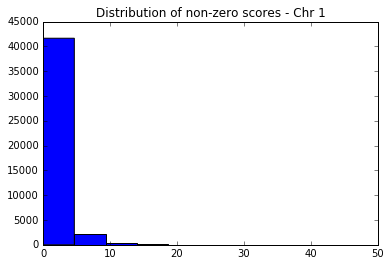

In [23]:
PPMatrix = BuildMatrix(PromoterCaptureFile, InteractionsFileCaptureC, 'CaptureC')

# Distribution of ATAC-peaks in HindIII Fragments

## Overlap

In [253]:
Hind_w_ATAC_NoThres={} # key: number of HindIII-atacPeak overlaps, value: number of HindIII frags with so many overlaps
for interval in bed_intersection(PromoterCaptureFile, ATACPeakFile, bed_out=True, bed_out_name=OutputFile, f=1e-14, F=1e-14):
    if interval.count not in Hind_w_ATAC_NoThres:
        Hind_w_ATAC_NoThres[interval.count]=1
    else:
        Hind_w_ATAC_NoThres[interval.count]=Hind_w_ATAC_NoThres[interval.count]+1

In [254]:
Hind_w_ATAC_Thres05={} # key: number of overlaps, value: number of HindIII frags with so many overlaps
for interval in bed_intersection(PromoterCaptureFile, ATACPeakFile, bed_out=True, bed_out_name=OutputFile, f=0.5, F=0.5):
    if interval.count not in Hind_w_ATAC_Thres05:
        Hind_w_ATAC_Thres05[interval.count]=1
    else:
        Hind_w_ATAC_Thres05[interval.count]=Hind_w_ATAC_Thres05[interval.count]+1

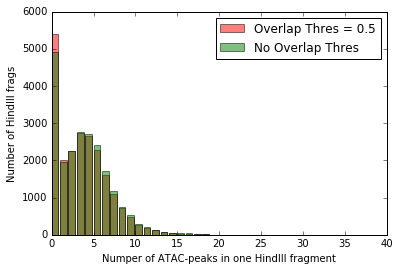

In [255]:
plt.bar(Hind_w_ATAC_Thres05.keys(), Hind_w_ATAC_Thres05.values(), alpha=0.5, color='r',  label='Overlap Thres = 0.5')
plt.bar(Hind_w_ATAC_NoThres.keys(), Hind_w_ATAC_NoThres.values(), alpha=0.5,  color='g', label='No Overlap Thres')
plt.xlabel('Numper of ATAC-peaks in one HindIII fragment')
plt.ylabel('Number of HindIII frags')
plt.legend(loc='upper right')
plt.show()

In [256]:
Hind_w_ATAC_NoThres

{0: 4901,
 1: 1957,
 2: 2258,
 3: 2775,
 4: 2706,
 5: 2401,
 6: 1702,
 7: 1170,
 8: 754,
 9: 520,
 10: 293,
 11: 210,
 12: 134,
 13: 84,
 14: 50,
 15: 40,
 16: 35,
 17: 31,
 18: 17,
 19: 7,
 20: 5,
 21: 6,
 22: 3,
 23: 4,
 24: 7,
 26: 2,
 28: 1,
 31: 1,
 36: 1,
 37: 1}

In [257]:
Hind_w_ATAC_Thres05

{0: 5393,
 1: 2022,
 2: 2253,
 3: 2734,
 4: 2652,
 5: 2280,
 6: 1607,
 7: 1107,
 8: 713,
 9: 475,
 10: 267,
 11: 185,
 12: 126,
 13: 79,
 14: 41,
 15: 31,
 16: 33,
 17: 28,
 18: 17,
 19: 5,
 20: 6,
 21: 4,
 22: 4,
 23: 4,
 24: 4,
 26: 2,
 28: 1,
 31: 1,
 36: 1,
 37: 1}

In [258]:
OverlapNodes = []
for interval in bed_intersection(PromoterCaptureFile, ATACPeakFile, bed_out=True, bed_out_name=OutputFile, f=0.5, F=0.5):
    OverlapNodes.append(interval.count)
OverlapNodes=np.array(OverlapNodes)
# indecies for HindIII nodes that
indx_noATAC = (OverlapNodes == 0) # don't overlap any ATAC peak
indx_ATAC = (OverlapNodes > 0) # overlap ATAC peaks
indx_ATAC_less10 = (OverlapNodes > 0) & (OverlapNodes <= 10) # overlap less than 10 ATAC peaks
indx_ATAC_more10 = (OverlapNodes >  10) # overlap more than 10 ATAC peaks
#sum(Nodes_noATAC)+sum(Nodes_ATAC_less10)+sum(Nodes_noATAC_more10)

In [259]:
matrix_noATAC = get_matrix(indx_noATAC.astype(np.int)[0:2272]) #chr1
matrix_ATAC = get_matrix(indx_ATAC.astype(np.int)[0:2272])
matrix_ATAC_less10 = get_matrix(indx_ATAC_less10.astype(np.int)[0:2272]) #chr1
matrix_ATAC_more10 = get_matrix(indx_ATAC_more10.astype(np.int)[0:2272]) #chr1

In [260]:
print sum(indx_noATAC[0:2272]), sum(indx_ATAC_less10[0:2272]), sum(indx_ATAC_more10[0:2272]), sum(indx_ATAC[0:2272])

538 1681 53 1734


1.0
(2272, 2272)
Limit: 1.0


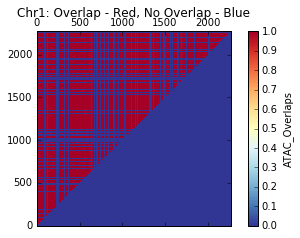

In [261]:
printMatrix(matrix_ATAC, 'ATAC_Overlaps', 1, 1, title='Chr1: Overlap - Red, No Overlap - Blue')

32.5660281516
(100, 2272)
Limit: 32.5660281516


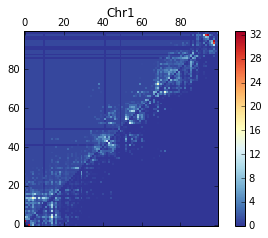

In [262]:
printMatrix(matrix_ATAC[0:100][0:100]+PPMatrix[0:100][0:100], '', 1, 1, title='Chr1')

3.0
(100, 2272)
Limit: 3.0


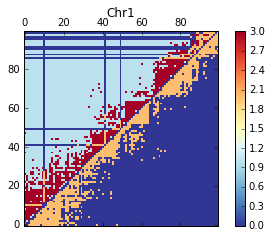

In [263]:
printMatrix(matrix_ATAC[0:100][0:100]+2*binarize(PPMatrix[0:100][0:100]), '', 1, 1, title='Chr1')

32.5660281516
(200, 2272)
Limit: 32.5660281516


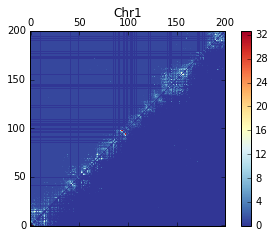

In [264]:
printMatrix(matrix_ATAC[0:200][0:200]+PPMatrix[0:200][0:200], '', 1, 1, title='Chr1')

3.0
(200, 2272)
Limit: 3.0


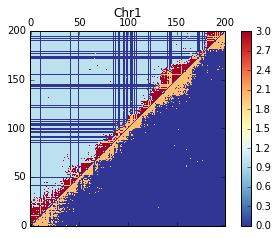

In [265]:
printMatrix(matrix_ATAC[0:200][0:200]+2*binarize(PPMatrix[0:200][0:200]), '', 1, 1, title='Chr1')

32.5660281516
(400, 2272)
Limit: 32.5660281516


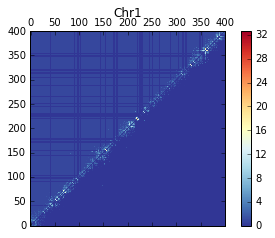

In [266]:
printMatrix(matrix_ATAC[0:400][0:400]+PPMatrix[0:400][0:400], '', 1, 1, title='Chr1')

3.0
(400, 2272)
Limit: 3.0


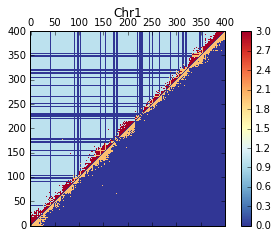

In [267]:
printMatrix(matrix_ATAC[0:400][0:400]+2*binarize(PPMatrix[0:400][0:400]), '', 1, 1, title='Chr1')

### Node Degree Distribution of HindIII fragments w and w/o ATAC peaks

Mean = 19.7514417532  w ATAC Overlap
Mean = 18.8717472119  w/o ATAC Overlap


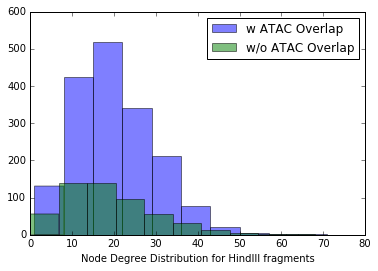

In [268]:
NodeDegreePP=get_nodeDegree_ForEachNode(binarize(PPMatrix[0:2272][0:2272]))
#NodeDegreePP=get_nodeDegree_ForEachNode(PPMatrix[0:2272][0:2272])
NodeDegree_noATAC = get_NodeDegree(NodeDegreePP[0:2272], indx_noATAC[0:2272])
NodeDegree_ATAC = get_NodeDegree(NodeDegreePP[0:2272], indx_ATAC[0:2272])
NodeDegree_ATAC_less10 = get_NodeDegree(NodeDegreePP[0:2272], indx_ATAC_less10[0:2272])
NodeDegree_ATAC_more10 = get_NodeDegree(NodeDegreePP[0:2272], indx_ATAC_more10[0:2272])

print "Mean =", NodeDegree_ATAC.mean(), " w ATAC Overlap"
print "Mean =", NodeDegree_noATAC.mean(), " w/o ATAC Overlap"

plt.hist(NodeDegree_ATAC,  alpha=0.5, label='w ATAC Overlap')
plt.hist(NodeDegree_noATAC,  alpha=0.5, label='w/o ATAC Overlap')
plt.xlabel('Node Degree Distribution for HindIII fragments')
plt.legend(loc='upper right')
plt.show()


### "Weighted" Node Degree Distribution of HindIII fragments w and w/o ATAC peaks

Mean = 32.9816745321  w ATAC Overlap
Mean = 28.6278319617  w/o ATAC Overlap


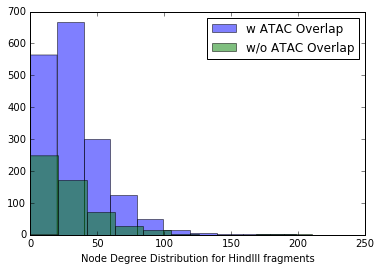

In [269]:
#NodeDegreePP=get_nodeDegree_ForEachNode(binarize(PPMatrix[0:2272][0:2272]))
NodeDegreePP=get_nodeDegree_ForEachNode(PPMatrix[0:2272][0:2272])
NodeDegree_noATAC = get_NodeDegree(NodeDegreePP[0:2272], indx_noATAC[0:2272])
NodeDegree_ATAC = get_NodeDegree(NodeDegreePP[0:2272], indx_ATAC[0:2272])
NodeDegree_ATAC_less10 = get_NodeDegree(NodeDegreePP[0:2272], indx_ATAC_less10[0:2272])
NodeDegree_ATAC_more10 = get_NodeDegree(NodeDegreePP[0:2272], indx_ATAC_more10[0:2272])

print "Mean =", NodeDegree_ATAC.mean(), " w ATAC Overlap"
print "Mean =", NodeDegree_noATAC.mean(), " w/o ATAC Overlap"

plt.hist(NodeDegree_ATAC,  alpha=0.5, label='w ATAC Overlap')
plt.hist(NodeDegree_noATAC,  alpha=0.5, label='w/o ATAC Overlap')
plt.xlabel('Node Degree Distribution for HindIII fragments')
plt.legend(loc='upper right')
plt.show()

### Node Degree Distribution of HindIII fragments w and w/o ATAC peaks only for high-confidence links

Mean = 10.0057670127  w ATAC Overlap
Mean = 9.08550185874  w/o ATAC Overlap


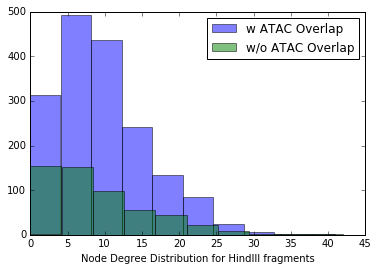

In [270]:
NodeDegreePP=get_nodeDegree_ForEachNode(binarize(get_confidentLinks(PPMatrix, 1)[0:2272][0:2272]))
NodeDegree_noATAC = get_NodeDegree(NodeDegreePP[0:2272], indx_noATAC[0:2272])
NodeDegree_ATAC = get_NodeDegree(NodeDegreePP[0:2272], indx_ATAC[0:2272])
NodeDegree_ATAC_less10 = get_NodeDegree(NodeDegreePP[0:2272], indx_ATAC_less10[0:2272])
NodeDegree_ATAC_more10 = get_NodeDegree(NodeDegreePP[0:2272], indx_ATAC_more10[0:2272])

print "Mean =", NodeDegree_ATAC.mean(), " w ATAC Overlap"
print "Mean =", NodeDegree_noATAC.mean(), " w/o ATAC Overlap"
#print "Mean =", NodeDegree_ATAC[NodeDegree_ATAC !=0].mean(), " w ATAC Overlap"
#print "Mean =", NodeDegree_noATAC[NodeDegree_noATAC !=0].mean(), " w/o ATAC Overlap"

plt.hist(NodeDegree_ATAC,  alpha=0.5, label='w ATAC Overlap')
plt.hist(NodeDegree_noATAC,  alpha=0.5, label='w/o ATAC Overlap')
plt.xlabel('Node Degree Distribution for HindIII fragments')
plt.legend(loc='upper right')
plt.show()

### Node Degree Distribution for nodes with more than 10 ATAC-peaks

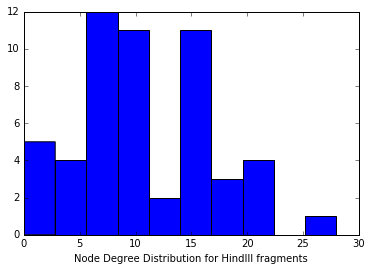

In [271]:
plt.hist(NodeDegree_ATAC_more10)
plt.xlabel('Node Degree Distribution for HindIII fragments')

# Distance to Closest ATAC-peak

In [272]:
file_UniqueATACPeak=DATADIR+'SORTED_primary_keratinocyte-d00.GGR.Stanford_Greenleaf.ATAC-seq.b1.trim.PE2SE.nodup.tn5_pooled.pf.pval0.1.500000.naive_overlap.narrowPeak.gz'
file_HindIII_w_noIntersection=DATADIR+'out_HindIII_NoIntersection'
file_HindIII_closestATAC=DATADIR+'out_HindIII_closestATAC'

In [273]:
bed_w_NoIntersection(PromoterCaptureFile, file_UniqueATACPeak, file_HindIII_w_noIntersection, featuretype=0, f=0.5, F=0.5)

<BedTool(/users/mtaranov/3D_fromATAC/data/out_HindIII_NoIntersection)>

(array([  2.32400000e+03,   1.57800000e+03,   8.78000000e+02,
          3.85000000e+02,   1.53000000e+02,   5.30000000e+01,
          1.30000000e+01,   7.00000000e+00,   0.00000000e+00,
          2.00000000e+00]),
 array([   37. ,   134.4,   231.8,   329.2,   426.6,   524. ,   621.4,
          718.8,   816.2,   913.6,  1011. ]),
 <a list of 10 Patch objects>)

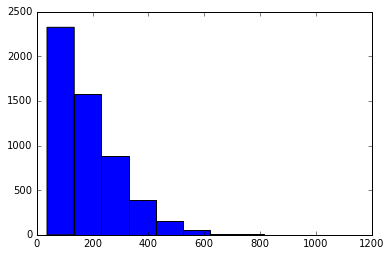

In [274]:
frags_closest_to_ATAC={}
for interval in bed_closest(file_HindIII_w_noIntersection, file_UniqueATACPeak, bed_out=True, bed_out_name=file_HindIII_closestATAC, io=True):
    if interval[3] not in frags_closest_to_ATAC:
        frags_closest_to_ATAC[interval[3]] = [interval.count]
    else:
        frags_closest_to_ATAC[interval[3]].append(interval.count)
    #dist_to_closest_ATAC.append(interval.count)
plt.hist([min(value) for value in frags_closest_to_ATAC.itervalues()])